# ERP Group Analysis

In [1]:
import mne
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pyarrow.feather as feather
from scipy.stats import zscore
import os.path as op
from glob import glob
from pathlib import Path
mne.set_log_level('ERROR')

In [ ]:
%cd 3137_2024-25_EEG
!git pull

In [2]:
source_path = op.join('..', 'derivatives')

derivatives_path = op.join(source_path, 'erp_measurement')
if Path(derivatives_path).exists() == False:
    Path(derivatives_path).mkdir(parents=True)

subjects = sorted([s[-7:] for s in glob(source_path + '/sub-*')])

In [3]:
epochs = {}
for subject in subjects:
    subj_path = op.join(source_path, subject)
    epochs[subject] = mne.read_epochs(op.join(source_path, subject, subject + '-epo.fif'),
                                         verbose=None, 
                                         preload=True)

# Create evoked


In [4]:
conditions = ['prime/related', 'target/related',
              'prime/unrelated', 'target/unrelated']

In [5]:
evoked = {}
for subject in subjects:
  for condition in conditions:
    evoked[subject] = epochs[subject][condition].average()

In [6]:
evoked = {}
for condition in conditions:
  evoked[condition] = []
  for subject in subjects:
    evoked[condition].append(epochs[subject][condition].average())

# Grand averages across subjects

In [7]:
gavg = {}

for condition in conditions:
    print(condition)
    gavg[condition] = mne.grand_average(evoked[condition])

prime/related
target/related
prime/unrelated
target/unrelated


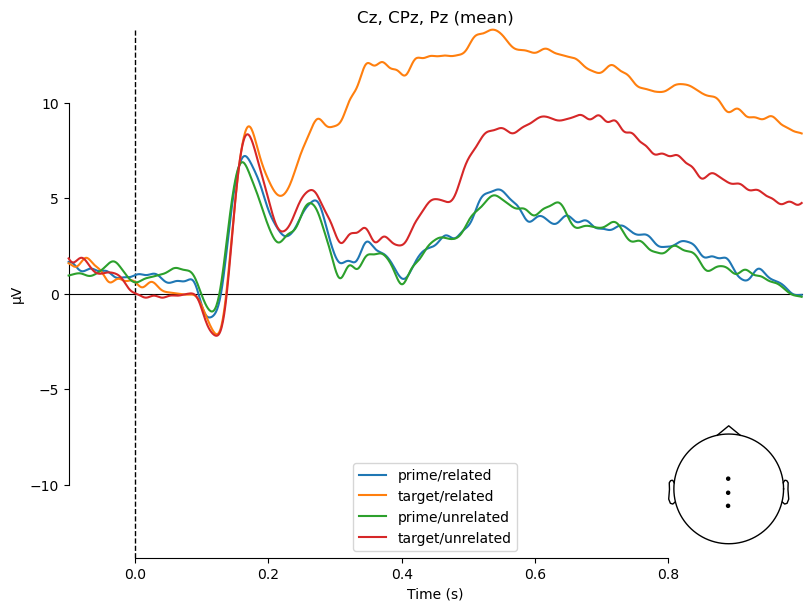

In [8]:
roi = ['Cz', 'CPz', 'Pz']
mne.viz.plot_compare_evokeds({c:evoked[c] for c in conditions},
                              picks=roi, combine='mean',
                              show_sensors='lower right', legend='lower center', 
                              ci=False,
                            );

# Compute difference waves between conditions

In [9]:
contrasts = {'related': ['prime/related', 'target/related'],
             'unrelated': ['prime/unrelated', 'target/unrelated'],
             'mismatch': ['target/unrelated', 'target/related']
             }

evoked_diff = {}
for contrast, conditions in contrasts.items():
  evoked_diff[contrast] = [mne.combine_evoked([ c1, c2],
                                          weights=[1, -1])
                                        for (c1, c2) in zip(evoked[conditions[0]], evoked[conditions[1]])
                                        ]
  

## Plot difference waves

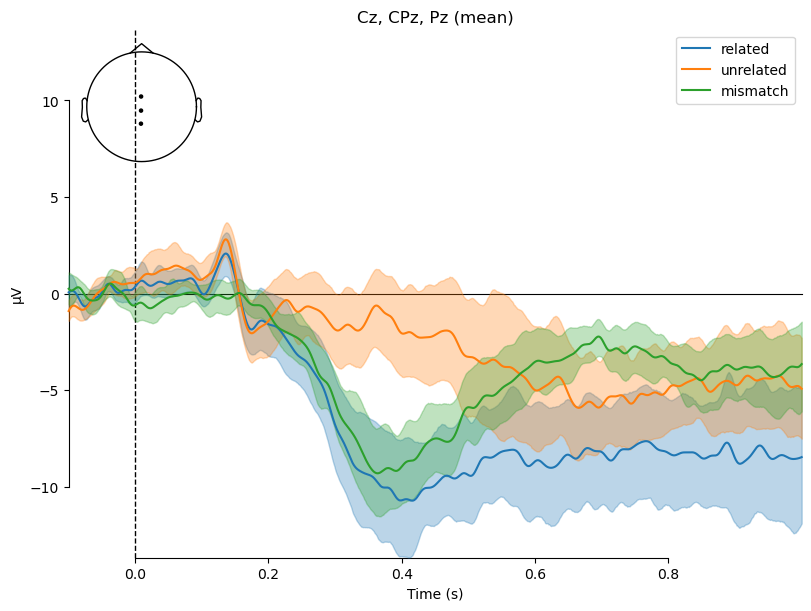

In [10]:
roi = ['Cz', 'CPz', 'Pz']
mne.viz.plot_compare_evokeds(evoked_diff, 
                             picks=roi, 
                             show_sensors='upper left', 
                             legend='upper right',
                             combine='mean',
                            #  ylim = {'eeg': (-3, 3)}
                             )
                             
plt.show()

# Plot scalp topographies of difference waves


 related


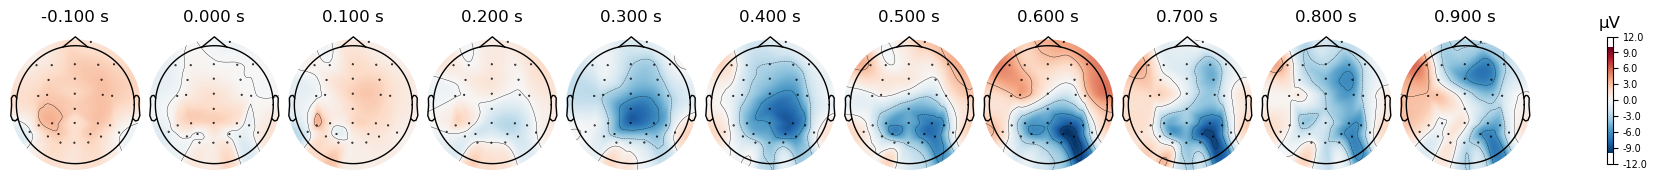


 unrelated


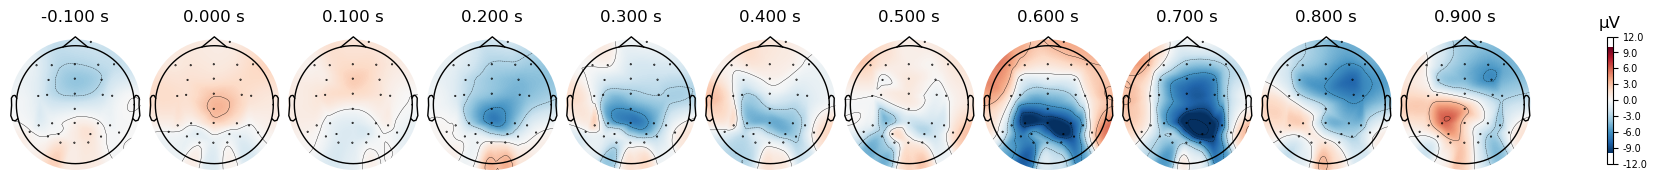


 mismatch


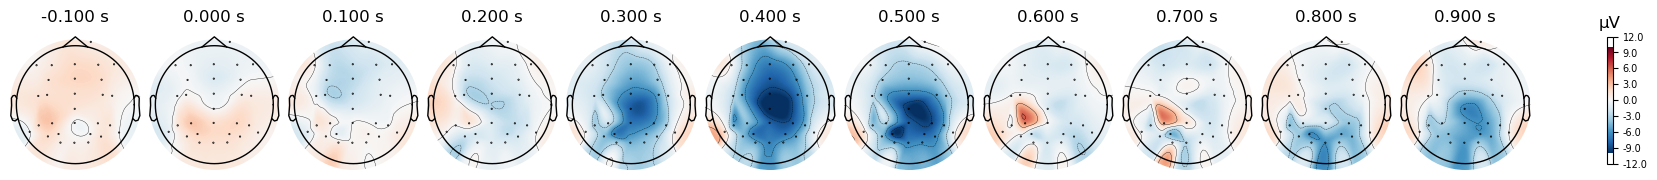

In [12]:
tmin = -0.100
tmax =  1.000
times = np.arange(tmin, tmax, .100)
uv_range = 10

for contrast in contrasts:
  print('\n', contrast)
  evoked_diff[contrast][0].plot_topomap(times, 
                                       ch_type='eeg', 
                                       vlim=[-uv_range, uv_range], 
                                       )